In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from itertools import combinations

In [200]:
# Red Blue Green Yellow Pink White

colors = 'rgbypw'

patterns = pd.DataFrame(combinations(colors * 4, r=4), columns=['1', '2', '3', '4'])
patterns['pattern'] = patterns.sum(axis=1)
patterns.set_index('pattern', inplace=True)
patterns.drop_duplicates(inplace=True)
patterns['is_valid'] = True

In [201]:
patterns.head()

,1,2,3,4,is_valid
pattern,,,,,
rgby,r,g,b,y,True
rgbp,r,g,b,p,True
rgbw,r,g,b,w,True
rgbr,r,g,b,r,True
rgbg,r,g,b,g,True


In [202]:
# In total, there are ~1,300 unique patterns.

len(patterns)

1296

In [203]:
# There are two main features I use for each pattern:
# The first is the count of each color within the pattern.
# The second is the count of each color at a specific position (1, 2, 3, 4) within the pattern.

colors = list(colors)
positions = [f'{position}{color}' for color in colors for position in range(1, 5)]

In [204]:
# For each color, I count the occurrences of that color within each pattern:

for color in colors:  
    patterns[color] = 0
    for position in range(1, 5):
        patterns[color] += patterns[f'{position}'] == color
        
patterns.head()

,1,2,3,4,is_valid,r,g,b,y,p,w
pattern,,,,,,,,,,,
rgby,r,g,b,y,True,1,1,1,1,0,0
rgbp,r,g,b,p,True,1,1,1,0,1,0
rgbw,r,g,b,w,True,1,1,1,0,0,1
rgbr,r,g,b,r,True,2,1,1,0,0,0
rgbg,r,g,b,g,True,1,2,1,0,0,0


In [205]:
# A pattern is considered valid if it contains no more than two of any color.
for color in colors:
    patterns['is_valid'] = patterns['is_valid'].mask(patterns[color] > 2, False)

In [206]:
# I double-check the counts for valid and invalid patterns to make sure that they match the original lists:

patterns['is_valid'].value_counts()

True     1170
False     126
Name: is_valid, dtype: int64

In [208]:
# To count the occurrences at each position, I use pandas' get_dummies function.
# This creates a column for every combination of (position, color). 
# The value for each column is 1 if the color is present in that position, and 0 if it is not present.

patterns = pd.concat([patterns, pd.get_dummies(patterns[['1', '2', '3', '4']], prefix_sep='')], axis=1)
patterns.head()

,1,2,3,4,is_valid,r,g,b,y,p,...,3p,3r,3w,3y,4b,4g,4p,4r,4w,4y
pattern,,,,,,,,,,,,,,,,,,,,,
rgby,r,g,b,y,True,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
rgbp,r,g,b,p,True,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
rgbw,r,g,b,w,True,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
rgbr,r,g,b,r,True,2,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
rgbg,r,g,b,g,True,1,2,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [209]:
# To make the first guess, I need to find the best pattern based on a metric.
# My metric is the sum of two scores:
# 1. Position score: how many valid patterns contain this color in this specific position?
# 2. Color score: how many valid patterns contain this color in any position?

# To calculate these scores, I first need a list of each valid pattern:

valid_patterns = patterns[patterns['is_valid']]

valid_positions = valid_patterns[positions].values

total_valid_patterns = valid_patterns.shape[0]

In [210]:
%%time

# I now calculate the position scores for the metric.
# The calculation is simple. I take the sum of each position column, and divide by the number of valid patterns:

position_scores = np.sum(valid_positions, axis=0) / total_valid_patterns * 100

CPU times: user 156 µs, sys: 36 µs, total: 192 µs
Wall time: 170 µs


In [211]:
%%time

# The color scores can be calculated similarly, but it's not necessary.
# Using the position scores, I group the scores by color and sum the groups.
# For example, the color score for "r" is the sum of ("1r", "2r", "3r", "4r").
# This process is much faster for large pattern banks with a time complexity of O(1) as opposed to O(num_patterns).

color_scores = position_scores.reshape((-1, 4)).sum(axis=1)

CPU times: user 52 µs, sys: 1e+03 ns, total: 53 µs
Wall time: 57.9 µs


In [212]:
# I now calculate each pattern's position and color score:

pattern_colors = patterns[colors].astype(bool).values
pattern_positions = patterns[positions].values

# I convert the color columns' type to boolean.
# This is to avoid double counting colors, like the color "m" in the pattern "mummy."

In [213]:
color_scores

array([66.66666667, 66.66666667, 66.66666667, 66.66666667, 66.66666667,
       66.66666667])

In [214]:
%%time

# The "color score" of a pattern is the sum of its colors' scores:

patterns['color_score'] = np.sum(color_scores * pattern_colors, axis=1)

CPU times: user 848 µs, sys: 222 µs, total: 1.07 ms
Wall time: 907 µs


In [215]:
%%time

# The "position score" of a pattern is the sum of its positions' scores:

patterns['position_score'] = np.sum(position_scores * pattern_positions, axis=1)

CPU times: user 1.67 ms, sys: 979 µs, total: 2.65 ms
Wall time: 1.75 ms


In [216]:
# The final score of a pattern is the sum of its "color score" and "position score":

patterns['score'] = patterns['color_score'] + patterns['position_score']

In [218]:
# Here are the five best patterns according to the "color score":

patterns['color_score'].sort_values(ascending=True).head()

# The three patterns containing all of the five most common colors have the highest score.

pattern
bbbb    66.666667
pppp    66.666667
yyyy    66.666667
gggg    66.666667
rrrr    66.666667
Name: color_score, dtype: float64

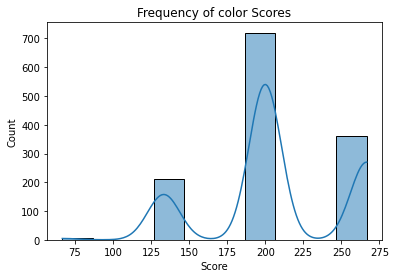

In [222]:
plt.title('Frequency of color Scores')
plt.xlabel('Score')
plt.ylabel('Count')

_ = sns.histplot(patterns.color_score, bins=10, kde=True)

In [224]:
# Now we're ready to solve some puzzles!

patterns.sort_values('score', ascending=False).to_pickle('../data/patterns.pkl')